This is just a test

In [2]:
from keras.models import Sequential, Model
from keras.layers import LSTM, GRU, SimpleRNN, RepeatVector, TimeDistributed, Dense, Input, Lambda
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import timedelta
import time

In [3]:
from tensorflow.python.client import device_lib
print("Avaiable tensorflow devices")
for d in device_lib.list_local_devices():
    print(" ->", d.name, "is a", d.device_type, "(", d.physical_device_desc, ")")

Avaiable tensorflow devices
 -> /device:CPU:0 is a CPU (  )
 -> /device:XLA_CPU:0 is a XLA_CPU ( device: XLA_CPU device )
 -> /device:XLA_GPU:0 is a XLA_GPU ( device: XLA_GPU device )
 -> /device:GPU:0 is a GPU ( device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1 )


In [11]:
ALPHABET = '0123456789- '
DIGITS = 3
DATA_CREATION_AMOUNT = 10
MAX_EXPONENT = 5
TEST_SIZE = 0.2

In [12]:
TRAINING_SERIES_LEN = MAX_EXPONENT + 1

HIDDEN_SIZE = 256
EPOCHS = 50
ALPHABET_LENGTH = len(ALPHABET)
MAXLEN = (DIGITS + 1) * TRAINING_SERIES_LEN + (TRAINING_SERIES_LEN - 1) 

In [13]:
class OneHot(object):
    def __init__(self, characters):
        self.chars = sorted(set(characters))
        self.char_to_index = dict((char, i) for i, char in enumerate(self.chars))
        self.index_to_char = dict((i, char) for i, char in enumerate(self.chars))

    def encode(self, string, length):
        enc = np.zeros((length, len(self.chars)))
        for i, char in enumerate(string):
            enc[i, self.char_to_index[char]] = 1
        for i in range(len(string), length):
            enc[i, self.char_to_index[' ']] = 1
        return enc
    
    def decode(self, mat):            
        return "".join([self.decode_line(mat[x]) for x in range(mat.shape[0])])
    
    def decode_line(self, vec):
        return self.index_to_char[np.argmax(vec)]

In [14]:
def create_data(size, train_series_len, max_exp=9, min_factor=-9, max_factor=9, digits=DIGITS):
    X = []
    y = []
    hist = []
    max_value = 10 ** digits - 1
    min_value = -max_value
    value_store = set()
    while len(X) < size:
        exp = np.random.randint(low=1, high=max_exp + 1)
        
        series_len = np.random.randint(low=exp + 1, high=train_series_len + 1, size=1)[0]
        
        factors = np.random.randint(low=min_factor, high=max_factor + 1, size=exp + 1)
        
        fun = lambda _i: sum(f * (_i ** x) for x, f in enumerate(factors))
        
        series = tuple(fun(i) for i in range(series_len + 1))
        
        if not series in value_store and all(min_value <= x <= max_value for x in series):
            X.append(" ".join([str(x) for x in series[:-1]]))
            y.append(str(series[-1]))
        
    return X, y

In [15]:
X, y = create_data(size=DATA_CREATION_AMOUNT, train_series_len=TRAINING_SERIES_LEN, max_exp=MAX_EXPONENT)

encoder = OneHot(ALPHABET)
for i in range(len(X)):
    X[i] = encoder.encode(X[i], MAXLEN)
    y[i] = encoder.encode(y[i], DIGITS + 1)
    
print(f"Created {len(X)} data points")

Created 10 data points


In [17]:
X = np.array(X)
y = np.array(y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val  :", X_val.shape)
print("y_val  :", y_val.shape)

X_train: (8, 29, 12)
y_train: (8, 4, 12)
X_val  : (2, 29, 12)
y_val  : (2, 4, 12)


In [20]:
lstn_input_shape = (MAXLEN, ALPHABET_LENGTH)

def create_model(layer_type=LSTM):

    _model = Sequential()
    _model.add(layer_type(HIDDEN_SIZE, input_shape=lstn_input_shape)) # Encoder
    _model.add(RepeatVector(DIGITS + 1))  # Stellt dem RNN im nächsten Schritt die Ausgabe des vorherigen bereit
    _model.add(layer_type(HIDDEN_SIZE, return_sequences=True)) # Decoder
    _model.add(TimeDistributed(Dense(ALPHABET_LENGTH, activation='softmax'))) # Wendet eine `Dense` Schicht auf jede Ausgabe des Decoders an
                                    # und ermittelt mittels 'softmax'-Funktion die Auswahlwahrscheinlichkeiten der Zeichen
        
    _model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return _model

ValueError: in user code:

    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 12]


In [ ]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [ ]:
def train(model, X_train, y_train, X_val, y_val, encoder, epochs):
    loss, acc, val_loss, val_acc = [], [], [], []
    for iteration in range(1, epochs + 1):
        print('-' * 50)
        print('Iteration', iteration)
        #print("X_train:", X_train.shape, "; y_train:", y_train.shape)
        hist = model.fit(X_train, y_train,
                  batch_size=1000,
                  epochs=1,
                  validation_data=(X_val, y_val))
        loss.append(hist.history['loss'])
        acc.append(hist.history['accuracy'])
        val_loss.append(hist.history['val_loss'])
        val_acc.append(hist.history['val_accuracy'])
        if iteration % 5 == 0:
            for i in range(10):
                ind = np.random.randint(0, X_val.shape[0])
                rowx, rowy = X_val[ind], y_val[ind]
                strx = encoder.decode(rowx)
                stry = encoder.decode(rowy)
                preds = model.predict(np.array([rowx]))
                strpred = encoder.decode(preds[0])
                if stry.strip() == strpred.strip():
                    print('{}{} -> {} ☑(real:{}){}'.format(colors.ok, strx, strpred, stry, colors.close))
                else:
                    print('{}{} -> {} ☒(real:{}){}'.format(colors.fail, strx, strpred, stry, colors.close))
    return loss, acc, val_loss, val_acc

In [ ]:
model = create_model()

print("Training model:")
print(model.summary())

start = time.time()
loss, acc, val_loss, val_acc = train(model, X_train, y_train, X_val, y_val, encoder, EPOCHS)
end = time.time()

print("Training took", timedelta(seconds=end - start))

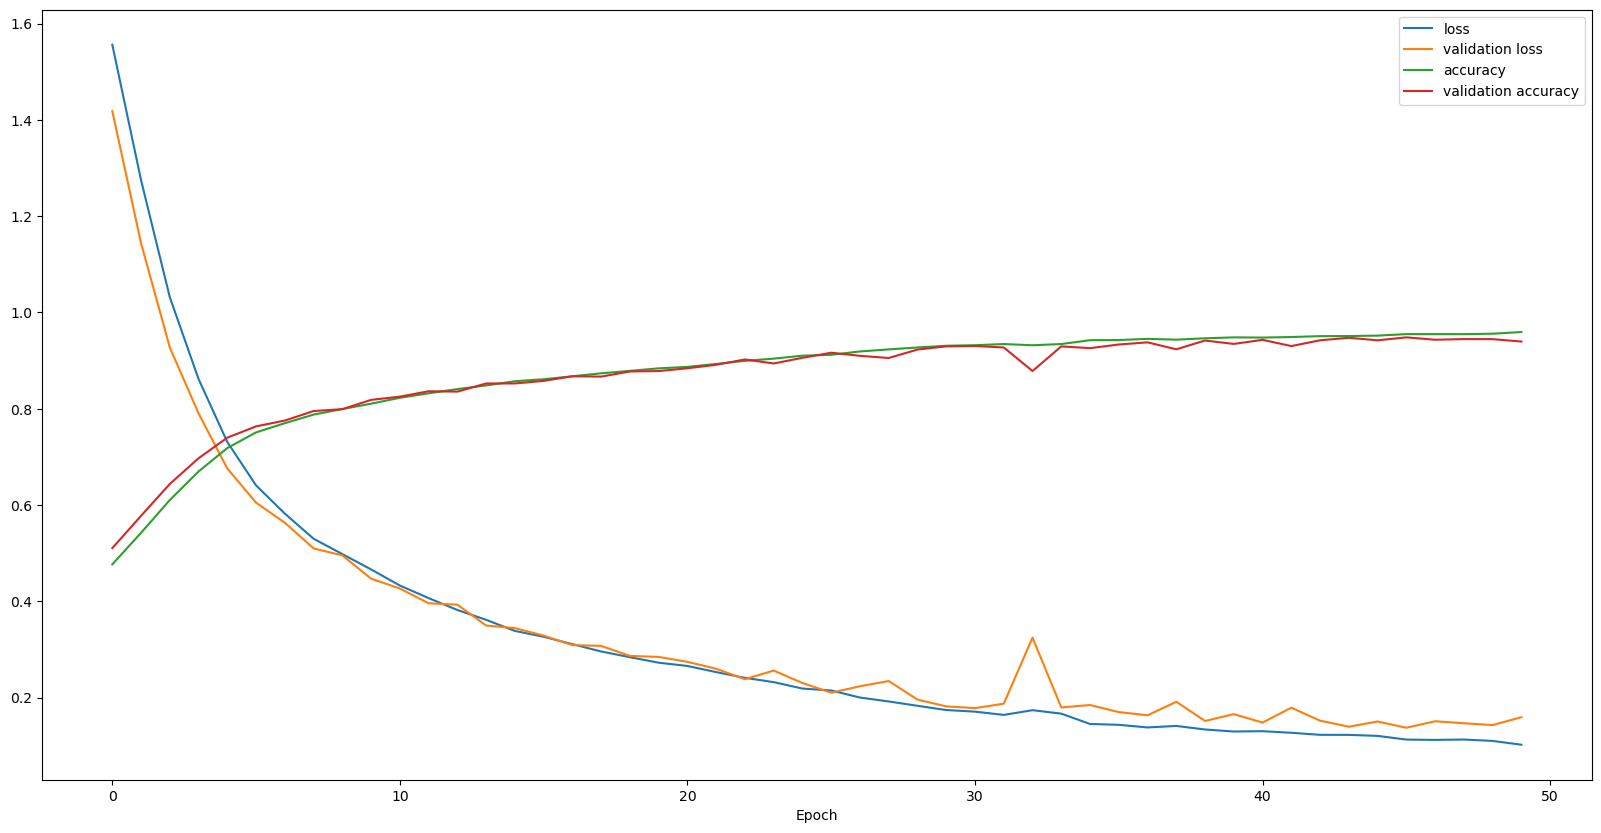

In [13]:
fig, ax = plt.subplots(1, 1)

ax.plot(loss, label='loss')
ax.plot(val_loss, label='validation loss')
ax.plot(acc, label='accuracy')
ax.plot(val_acc, label='validation accuracy')
ax.set_xlabel("Epoch")
ax.legend()
fig.set_size_inches(20, 10)

plt.show()

In [14]:
gru_model = create_model(GRU)

print("Training model:")
print(gru_model.summary())

start = time.time()
loss_gru, acc_gru, val_loss_gru, val_acc_gru = train(gru_model, X_train, y_train, X_val, y_val, encoder, EPOCHS)
end = time.time()

print("Training took", timedelta(seconds=end - start))

Training model:
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 256)               206592    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 4, 256)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 4, 256)            393984    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 4, 12)             3084      
Total params: 603,660
Trainable params: 603,660
Non-trainable params: 0
_________________________________________________________________
None
--------------------------------------------------
Iteration 1
Train on 400000 samples, validate on 100000 samples
Epoch 1/1
400000/400000 [==============================] - 29s 72us/step - loss: 1.5453 - accuracy: 0.4813 - v

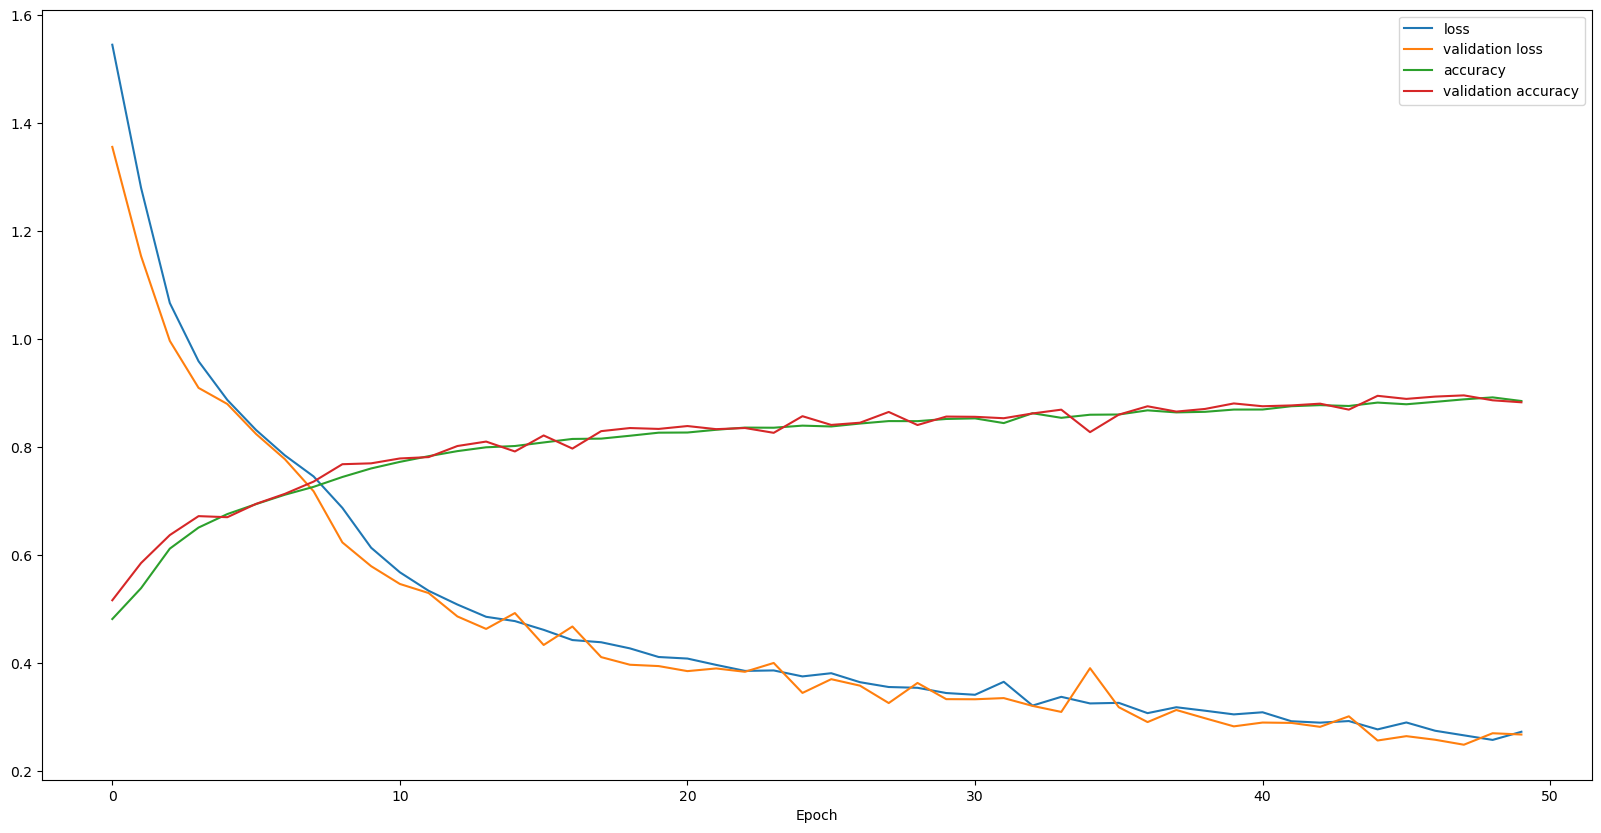

In [15]:
fig, ax = plt.subplots(1, 1)

ax.plot(loss_gru, label='loss')
ax.plot(val_loss_gru, label='validation loss')
ax.plot(acc_gru, label='accuracy')
ax.plot(val_acc_gru, label='validation accuracy')
ax.set_xlabel("Epoch")
ax.legend()
fig.set_size_inches(20, 10)

plt.show()

In [16]:
simple_rnn_model = create_model(SimpleRNN)

print("Training model:")
print(simple_rnn_model.summary())

start = time.time()
loss_simple, acc_simple, val_loss_simple, val_acc_simple = train(simple_rnn_model, X_train, y_train, X_val, y_val, encoder, EPOCHS)
end = time.time()

print("Training took", timedelta(seconds=end - start))

Training model:
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 256)               68864     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 4, 256)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 4, 256)            131328    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 4, 12)             3084      
Total params: 203,276
Trainable params: 203,276
Non-trainable params: 0
_________________________________________________________________
None
--------------------------------------------------
Iteration 1
Train on 400000 samples, validate on 100000 samples
Epoch 1/1
400000/400000 [==============================] - 16s 41us/step - loss: 1.3016 - accuracy: 0.5463 - v

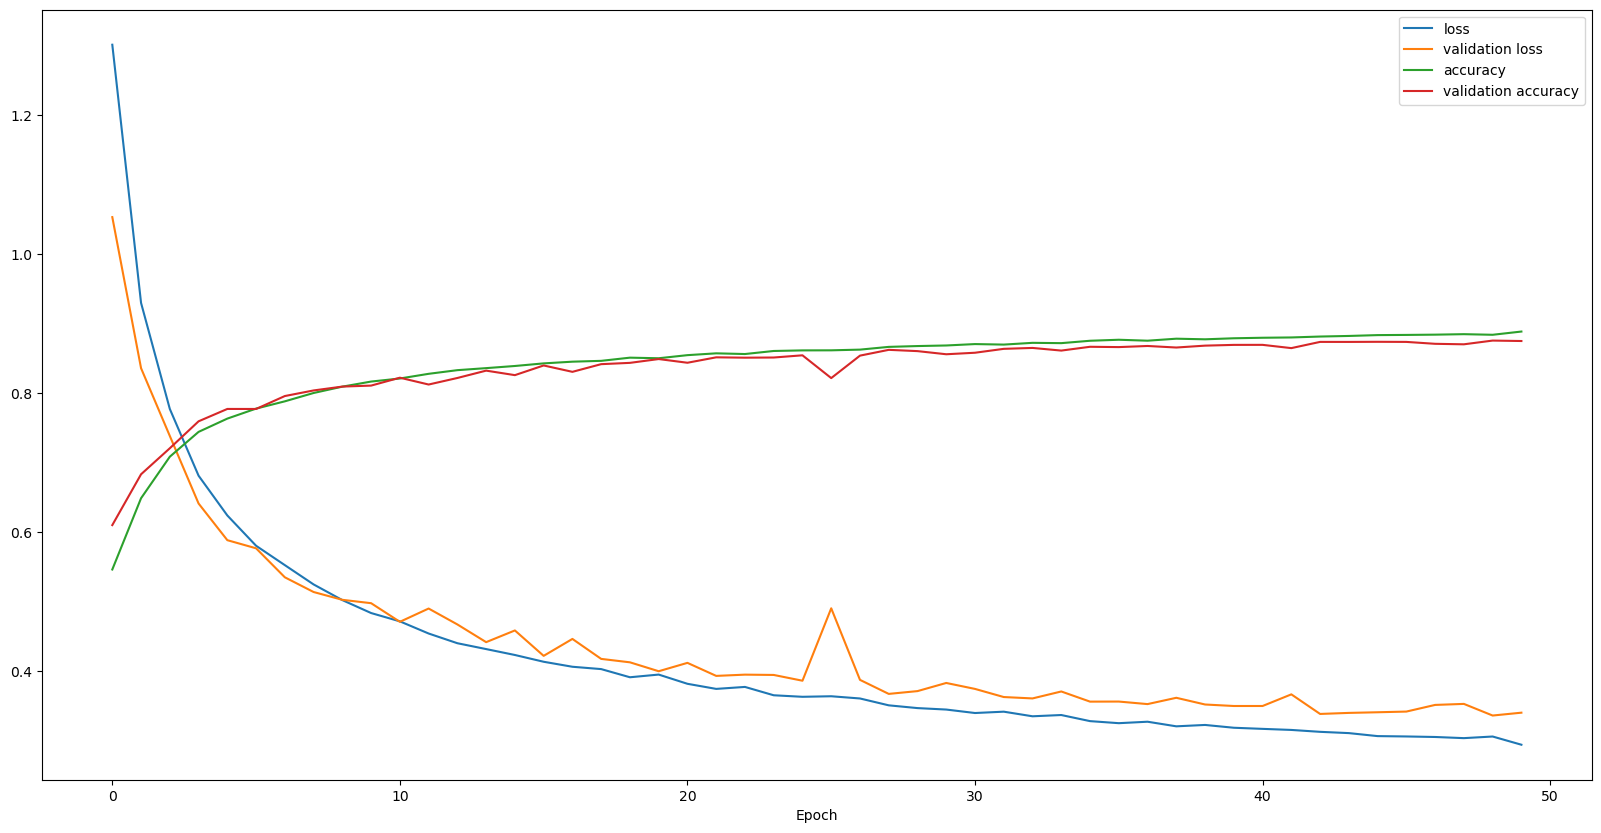

In [17]:
fig, ax = plt.subplots(1, 1)

ax.plot(loss_simple, label='loss')
ax.plot(val_loss_simple, label='validation loss')
ax.plot(acc_simple, label='accuracy')
ax.plot(val_acc_simple, label='validation accuracy')
ax.set_xlabel("Epoch")
ax.legend()
fig.set_size_inches(20, 10)

plt.show()

SimpleRNN ended on: loss: [0.29414929188787936] ; validation loss: [0.3402622690796852] ; accuracy: [0.88881564] validation accuracy: [0.875190019607544]
GRU ended on: loss: [0.27235221311450003] ; validation loss: [0.2672745157778263] ; accuracy: [0.8852056] validation accuracy: [0.8828225135803223]
LSTM ended on: loss: [0.10219086637720466] ; validation loss: [0.1593789680302143] ; accuracy: [0.9593656] validation accuracy: [0.9395999908447266]


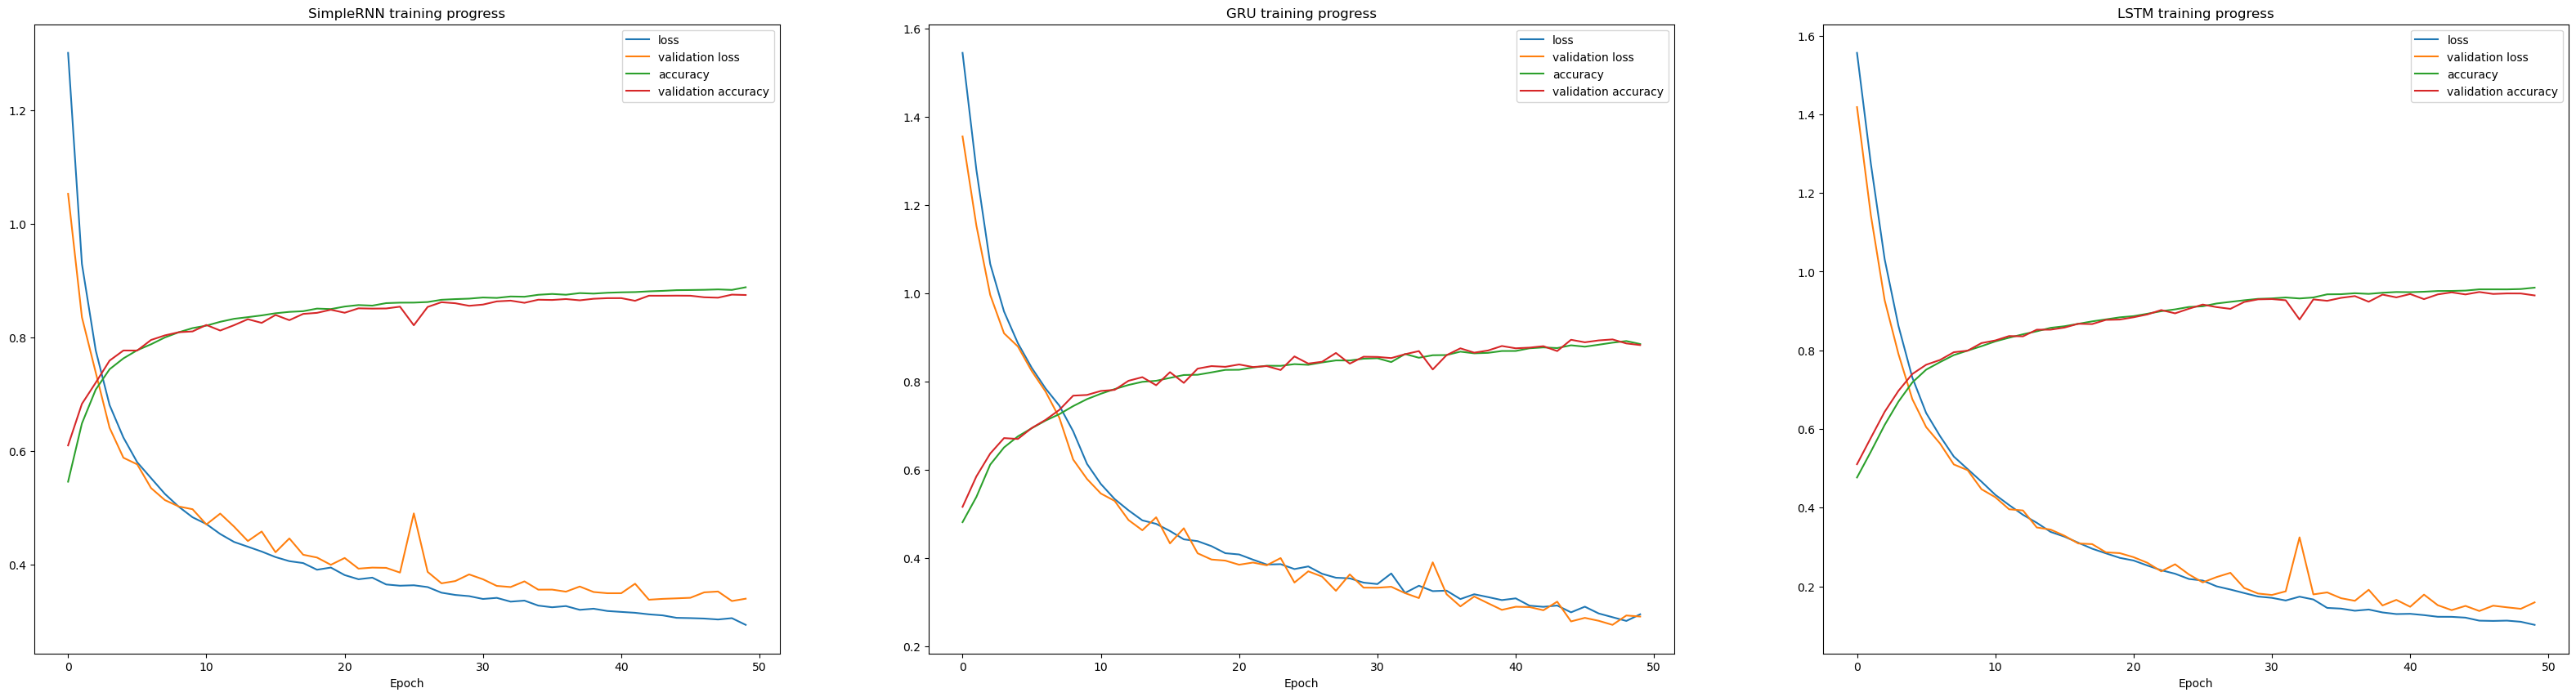

In [18]:
fig, ax = plt.subplots(1, 3)

for i, (n, l, vl, a, va) in enumerate([("SimpleRNN", loss_simple, val_loss_simple, acc_simple, val_acc_simple), ("GRU", loss_gru, val_loss_gru, acc_gru, val_acc_gru), ("LSTM", loss, val_loss, acc, val_acc)]):
    ax[i].plot(l, label='loss')
    ax[i].plot(vl, label='validation loss')
    ax[i].plot(a, label='accuracy')
    ax[i].plot(va, label='validation accuracy')
    ax[i].set_xlabel("Epoch")
    ax[i].set_title(f"{n} training progress")
    ax[i].legend()
    
    print(n, "ended on: loss:", l[-1], "; validation loss:", vl[-1], "; accuracy:", a[-1], "validation accuracy:", va[-1])


fig.set_size_inches(40, 10)

plt.show()

In [19]:
from IPython.display import display
from ipywidgets import interactive, fixed
import ipywidgets as widgets


def i_am_thinking(sequence, trained_models):
    encoded = np.array([encoder.encode(sequence, MAXLEN)])
    max_name_len = max(len(x[0]) for x in trained_models)
    tmpl = "{model_name:%s} thinks the following number to the sequence {sequence} is {result:>4}. {model_name:%s} is {sure:6.2f}%% sure" % (max_name_len, max_name_len)
    for model_name, trained_model in trained_models:

        result = trained_model.predict(encoded)

        i_am_sure = np.prod(result[0].max(axis=1), dtype=float)

        #print(np.argmax(result[0], axis=1))
        print(tmpl.format(model_name=model_name, sequence=encoder.decode(encoded[0]).strip(), result=encoder.decode(result[0]).strip(), sure=i_am_sure * 100))

w = interactive(i_am_thinking,
                sequence=widgets.Text(value='1 2 3 4', placeholder='Insert your sequence here', description='Number sequence', disabled=False),
                trained_models=fixed([("SimpleRNN", simple_rnn_model), ("LSTM", model), ("GRU", gru_model)]))

display(w)

interactive(children=(Text(value='1 2 3 4', description='Number sequence', placeholder='Insert your sequence h…